# Naive Bayes

## Introduction

We will start by working on the Iris dataset. Recall that Iris dataset contains iris species and sepal and petal measurements. We will quickly explore the dataset and jump into Naive Bayes.

In [84]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

* Load the Iris dataset.
* Take a quick look at the data types.
* Look at the skew values and decide if any transformations need to be applied. You can use skew value 0.75 as a threshold.
* Use `sns.pairplot` to plot the pairwise correlations and histograms. Use `hue="species"` as a keyword argument in order to see the distribution of species.

In [87]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Iris_Data.csv'])
data = pd.read_csv(filepath, sep=',', header=0)

In [89]:
data.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

Notice that aside from the predictor variable, everything is float.

In [92]:

numeric_data = data.select_dtypes(include=['number']) #select only numeric columns from the dataset


skew = pd.DataFrame(numeric_data.skew())
skew.columns = ['skew']
skew["too_skewed"] = skew['skew'] > 0.75


skew


,skew,too_skewed
sepal_length,0.314911,False
sepal_width,0.334053,False
petal_length,-0.274464,False
petal_width,-0.104997,False


Fields are not too badly skewed.

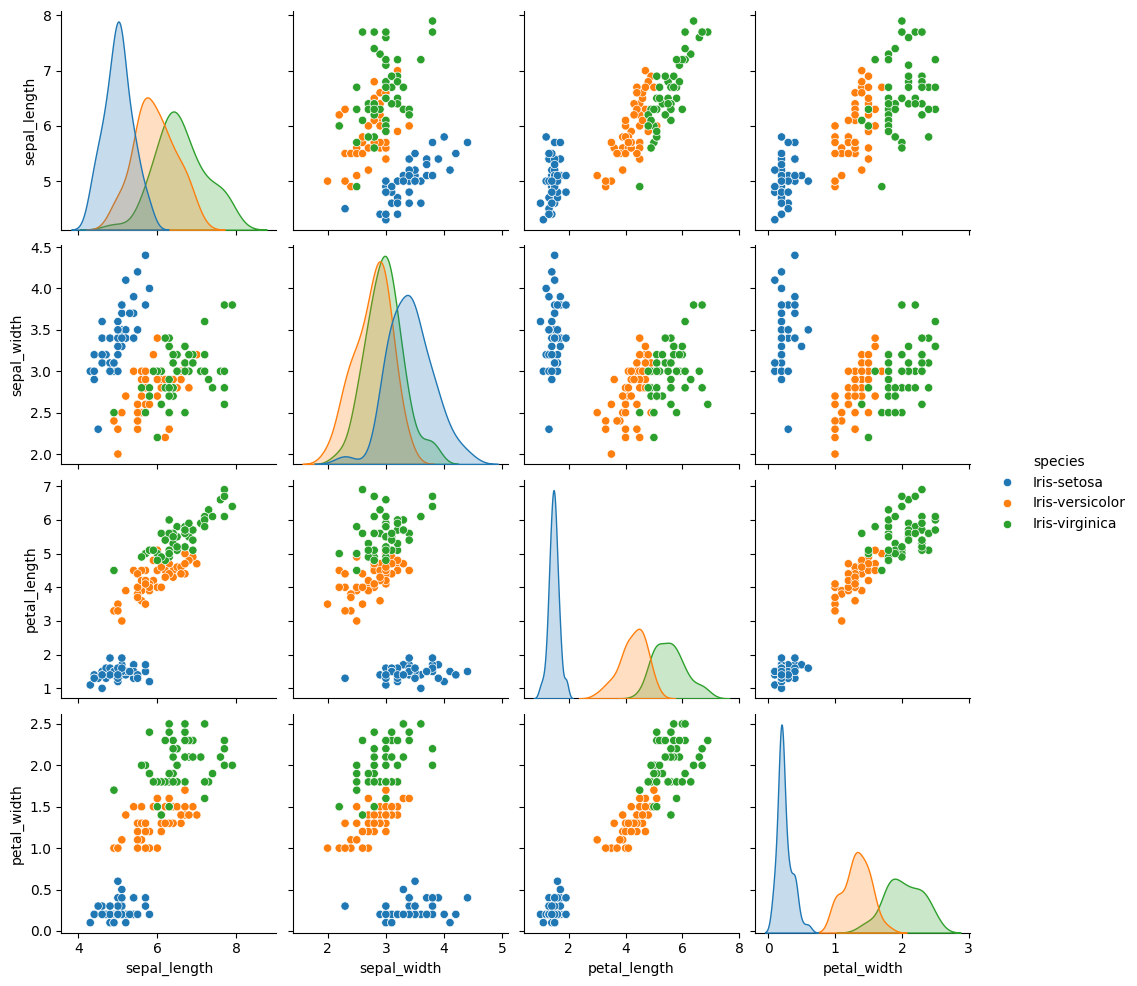

In [95]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(data, hue='species')
plt.show()

## Question 2

Let's now fit a Naive Bayes classifier to this data in order to predict "species".

* Pick the appropriate type of Naive Bayes given the nature of your dataset (data types of columns). Recall, choices are
    * GaussianNB
    * MultinomialNB
    * BernoulliNB
* Use `cross_val_score` to see how well your choice works.

In [97]:
# Since the features are continuous, the right choice is GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

X = data[data.columns[:-1]]
y = data.species

GNB = GaussianNB()
cv_N = 7
scores = cross_val_score(GNB, X, y, n_jobs=cv_N, cv=cv_N)

print(scores)
np.mean(scores)


[0.90909091 1.         0.90909091 0.95238095 0.9047619  1.
 1.        ]


0.953617810760668

## Question 3:

Now let's try all types of Naive Bayes and observe what happens

* Compare the cross validation scores for Gaussian, Bernouilli and Multinomial Naive Bayes.
* Why is BernoulliNB performing like it does?

In [99]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

X = data[data.columns[:-1]]
y = data.species

nb = {
    'gaussian': GaussianNB(),
    'bernoulli': BernoulliNB(),
    'multinomial': MultinomialNB()
}

scores = {}
for key, model in nb.items():
    s = cross_val_score(model, X, y, cv=cv_N, n_jobs=cv_N, scoring='accuracy')
    scores[key] = np.mean(s)

scores


{'gaussian': 0.953617810760668,
 'bernoulli': 0.3268398268398268,
 'multinomial': 0.9659863945578231}

Looks like BernoulliNB results are very bad, but MultinomialNB is doing a very good job.

Why are the results of Bernoulli bad? Find out the reason.

## Question 4:

Let's see what happens when we take away the predictive features.

* Check the pairplot histograms (diagonal) you produced above and identify the two most predictive features visually.
* Remove the *petal_* features which are very predictive, and re-do the comparison above. That is, get the cross validation scores for all types of Naive Bayes.

In [102]:
X = data[['sepal_length', 'sepal_width']]
y = data.species

nb = {
    'gaussian': GaussianNB(),
    'bernoulli': BernoulliNB(),
    'multinomial': MultinomialNB()
}

scores = {}
for key, model in nb.items():
    s = cross_val_score(model, X, y, cv=cv_N, n_jobs=cv_N, scoring='accuracy')
    scores[key] = np.mean(s)

scores


{'gaussian': 0.8002473716759432,
 'bernoulli': 0.3268398268398268,
 'multinomial': 0.6536796536796537}

#Come up with your observations after taking away the very predictive features, which model works better

## Question 5

This question explores how Naive Bayes algorithms can be affected when we push the underlying (naive) assumption too much. Recall that the naive assumption is that the features in the training set are *independent* from each other.

* Create **0, 1, 3, 5, 10, 50, 100** copies of `sepal_length` and fit a `GaussianNB` for each one.
* Keep track of the save the average `cross_val_score`.
* Create a plot of the saved scores over the number of copies.

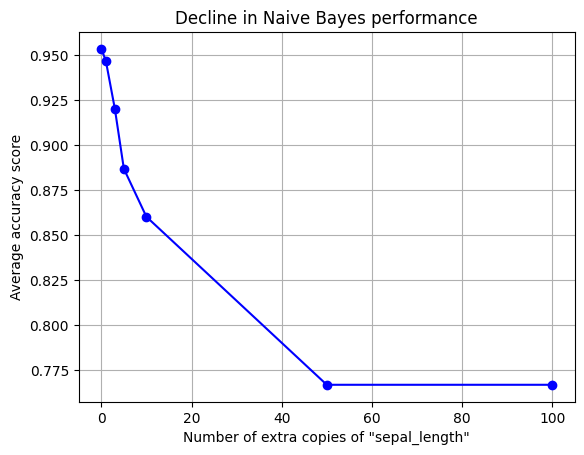

In [106]:

X = data[data.columns[:-1]]
y = data.species

n_copies = [0, 1, 3, 5, 10, 50, 100]

def create_copies_sepal_length(X, n):
    copies = [X]
    sepal_length_copy = X[['sepal_length']]
    for i in range(n):
        copies.append(sepal_length_copy.rename(columns={'sepal_length': f'sepal_length_copy_{i}'}))
    X_new = pd.concat(copies, axis=1) # use pd.concat instead
    return X_new

def get_cross_val_score(n):
    X_new = create_copies_sepal_length(X, n)
    scores = cross_val_score(GaussianNB(), X_new, y, cv=5, n_jobs=-1)
    return np.mean(scores)

avg_scores = pd.Series(
    [get_cross_val_score(n) for n in n_copies],
    index=n_copies
)

ax = avg_scores.plot(marker='o', linestyle='-', color='b')
ax.set(
    xlabel='Number of extra copies of "sepal_length"',
    ylabel='Average accuracy score',
    title='Decline in Naive Bayes performance'
)
plt.grid(True)
plt.show()


## Question 6 - Naive Bayes on Human Activity Recongnition

In this question, we'll explore discretizing the dataset and then fitting MultinomialNB.  

* Load the Human Activity Recognition dataset. 
* Look at the data types. It's all continuous except for the target.
* Create `X` and `y` from `data`. `y` is the "Activity" column.
* Create training and test splits.
* Fit a GaussianNB to the training split.
* Get predictions on the test set.
* use `sns.heatmap` to plot the confusion matrix for predictions.

In [108]:
import pandas as pd
import numpy as np



filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',', header=0)
data.dtypes.value_counts()


float64    561
object       1
Name: count, dtype: int64

In [109]:
from sklearn.model_selection import train_test_split

X = data.drop('Activity', axis=1)
y = data.Activity
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)


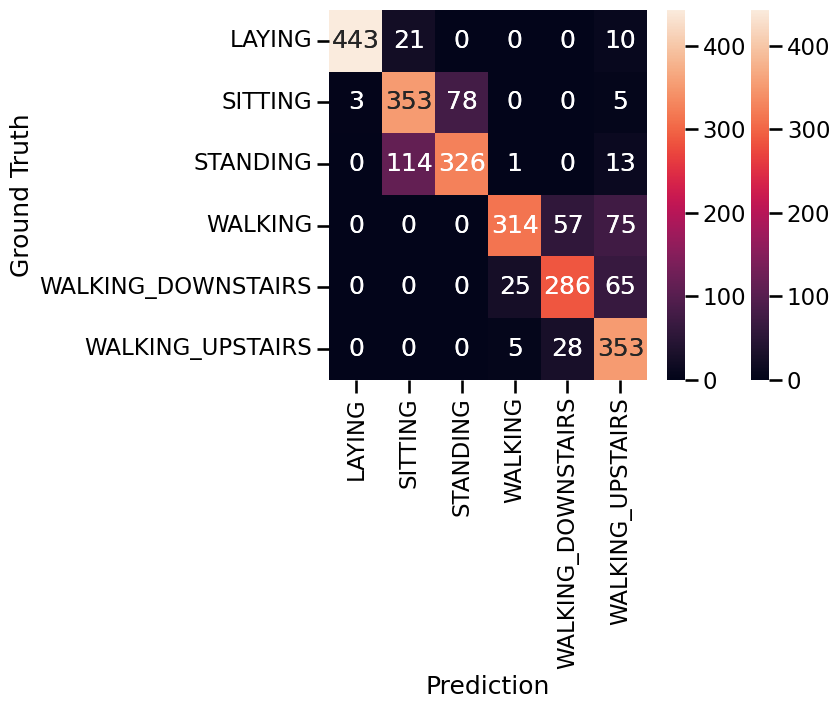

In [118]:
from sklearn.metrics import confusion_matrix

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = pd.Series(gnb.predict(Xtest))
labels = sorted(ytest.unique())

cm = pd.DataFrame(confusion_matrix(ytest, ypred, labels=labels),
                  columns=labels, index=labels)

sns.set_context('talk')
ax = sns.heatmap(cm, annot=True, fmt='d', yticklabels=True, xticklabels=True)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel('Ground Truth')
ax.set_xlabel('Prediction')
plt.show()


## Question 7

Now, let's discretize the dataset from Question 6. There are many ways to do this, but we'll use `pd.DataFrame.rank(pct=True)`.

a. Create `X_discrete` from `X` using .rank(pct=True)

b. Look at the values. They are still not discrete. Modify `X_discrete` so that it is indeed discrete. (Hint: try to get the first 2 digits using `.applymap`)

c. Split `X_discrete` and `y` into training and test datasets

d. Fit a MultinomialNB to the training split.

e. Get predictions on the test set.

f. Plot the confusion matrix for predictions.

In [120]:
X_discrete = X.rank(pct=True)
X_discrete.sample(5)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
9867,0.238858,0.775609,0.150112,0.860375,0.995922,0.688708,0.878823,0.995534,0.698320,0.844791,...,0.359549,0.590154,0.486940,0.859113,0.377415,0.900670,0.663754,0.626274,0.946014,0.477328
8240,0.098456,0.795514,0.140014,0.678221,0.550636,0.896204,0.692009,0.555005,0.892125,0.690261,...,0.354889,0.208564,0.137975,0.850180,0.474415,0.096029,0.947374,0.719682,0.282940,0.975823
7573,0.316730,0.424799,0.433537,0.082921,0.104767,0.030003,0.092533,0.100204,0.022721,0.123798,...,0.705894,0.108943,0.117099,0.893873,0.387610,0.260317,0.613749,0.892028,0.069327,0.113118
3110,0.475871,0.506360,0.567531,0.110108,0.025148,0.183610,0.108651,0.023692,0.203321,0.078503,...,0.801243,0.691621,0.764249,0.588018,0.408875,0.463540,0.832993,0.577823,0.546558,0.198175
971,0.967084,0.332848,0.664725,0.905816,0.948539,0.748519,0.912030,0.962035,0.774056,0.907224,...,0.395281,0.401107,0.394504,0.009127,0.089815,0.012914,0.494126,0.520245,0.878629,0.615108


In [122]:
X_discrete = X_discrete.applymap(lambda r: int(r * 100))
X_discrete.sample(5)


/var/folders/v0/_l0_v32n1f54t6h877vsg9wr0000gn/T/ipykernel_21436/1847049852.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_discrete = X_discrete.applymap(lambda r: int(r * 100))


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
9519,81,29,9,60,59,64,59,61,63,64,...,60,43,43,12,31,92,92,47,68,82
7707,83,12,73,52,49,46,52,49,45,53,...,10,98,97,89,17,44,57,92,4,14
3137,77,33,32,43,30,21,45,32,21,43,...,92,2,7,76,30,25,70,90,98,1
1925,11,99,4,46,65,48,46,69,49,2,...,27,59,58,45,62,52,27,68,20,20
2754,49,71,36,3,8,2,4,8,2,6,...,96,7,5,35,63,36,47,10,25,64


In [124]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_discrete, y)
mnb = MultinomialNB()
mnb.fit(Xtrain, ytrain)


MultinomialNB()

In [ ]:
ypred = pd.Series(mnb.predict(Xtest))
labels = sorted(ytest.unique())

cm = pd.DataFrame(confusion_matrix(ytest, ypred, labels=labels),
                  columns=labels, index=labels)

sns.set_context('talk')
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=True, yticklabels=True)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_ylabel('Prediction')
ax.set_xlabel('Ground Truth')
